In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

# Validation for homophily 0.25

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_homophily_025 = pd.read_csv("./parameters/parameters_optimization_palin_hours_homophily_0.25.csv")

In [15]:
parameters_homophily_025 = parameters_homophily_025.sort_values(by='rmse')
parameters_homophily_025

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
15,0.50,0.25,0.25,0.946572,0.019471,0.806971,0.485082,0.630385,3.665503
9,0.25,0.75,0.25,0.671159,0.315414,0.837163,0.938964,0.786240,4.061536
13,0.33,0.50,0.25,0.811651,0.122950,0.415625,0.641897,0.359864,4.579548
17,0.50,0.50,0.25,0.832157,0.178371,0.874119,0.533449,0.751942,7.440493
19,0.75,0.25,0.25,0.700935,0.313440,0.323507,0.646720,0.425415,10.167374
4,0.00,0.75,0.25,0.242011,0.047201,0.446475,0.831034,0.571795,11.283309
16,0.50,0.33,0.25,0.676409,0.451609,0.692063,0.950132,0.099987,11.821275
11,0.33,0.25,0.25,0.961665,0.087162,0.674789,0.873810,0.721106,14.995867
12,0.33,0.33,0.25,0.871039,0.214956,0.566959,0.946951,0.041759,15.466470
7,0.25,0.33,0.25,0.082344,0.310468,0.194199,0.899468,0.449386,22.524894


In [16]:
alpha = parameters_homophily_025['alpha'].iloc[0]
beta = parameters_homophily_025['beta'].iloc[0]
homophily = parameters_homophily_025['homophily'].iloc[0]
prob_infection = parameters_homophily_025['prob_infection'].iloc[0]
prob_vaccination = parameters_homophily_025['prob_vaccination'].iloc[0]
prob_cure = parameters_homophily_025['prob_cure'].iloc[0]
prob_influencer = parameters_homophily_025['prob_influencer'].iloc[0]
prob_echo = parameters_homophily_025['prob_echo'].iloc[0]

In [17]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [18]:
total_y_pred_list_homophily_025 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_homophily_025.append(y_pred_list)

In [19]:
avg_y_pred_list_homophily_025 = [sum(column) / len(column) for column in zip(*total_y_pred_list_homophily_025)]

In [20]:
std_y_pred_list_homophily_025 = [np.std(column) for column in zip(*total_y_pred_list_homophily_025)]

In [21]:
std_low_y_pred_list_homophily_025 = []
std_high_y_pred_list_homophily_025 = []
for i in range(len(avg_y_pred_list_homophily_025)):
    std_low_y_pred_list_homophily_025.append(avg_y_pred_list_homophily_025[i] - std_y_pred_list_homophily_025[i])
    std_high_y_pred_list_homophily_025.append(avg_y_pred_list_homophily_025[i] + std_y_pred_list_homophily_025[i])

In [22]:
x = []
for i in range(len(endorsers_percentage_list)):
    x.append(i)

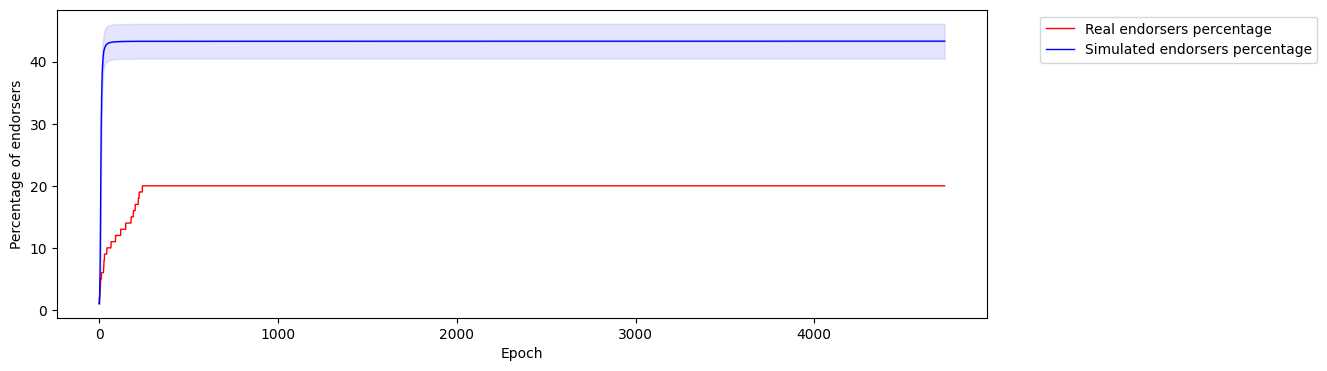

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_025, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_025, std_low_y_pred_list_homophily_025, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_025, std_high_y_pred_list_homophily_025, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [24]:
x = []
endorsers_percentage_list_truncated = []
avg_y_pred_list_homophily_025_truncated = []
std_low_y_pred_list_homophily_025_truncated = []
std_high_y_pred_list_homophily_025_truncated = []
for i in range(500):
    x.append(i)
    endorsers_percentage_list_truncated.append(endorsers_percentage_list[i])
    avg_y_pred_list_homophily_025_truncated.append(avg_y_pred_list_homophily_025[i])
    std_low_y_pred_list_homophily_025_truncated.append(std_low_y_pred_list_homophily_025[i])
    std_high_y_pred_list_homophily_025_truncated.append(std_high_y_pred_list_homophily_025[i])

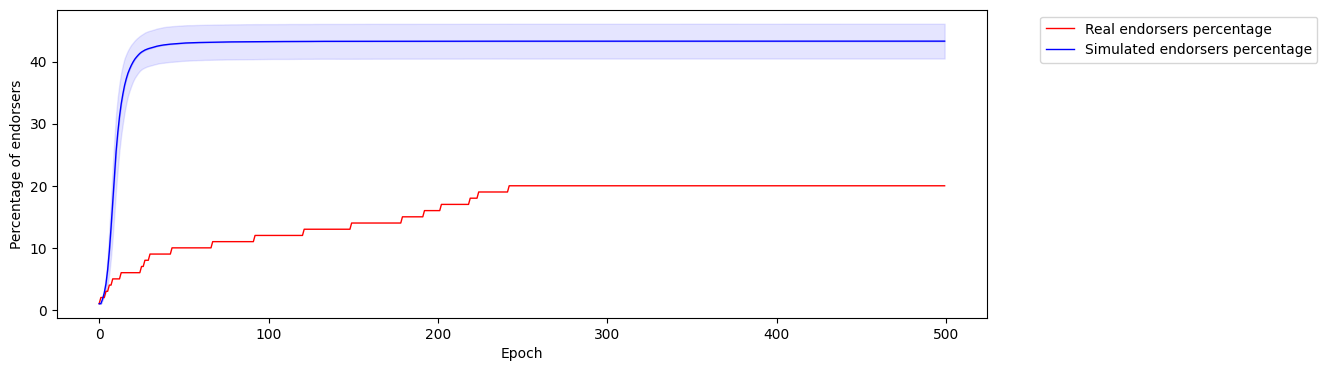

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list_truncated, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_025_truncated, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_025_truncated, std_low_y_pred_list_homophily_025_truncated, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_025_truncated, std_high_y_pred_list_homophily_025_truncated, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [26]:
y_true = endorsers_percentage_list

neg_rmse_list_homophily_025 = []
for i in range(container.n_networks):
        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_homophily_025[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_homophily_025.append(neg_rmse)
    
mean_neg_rmse_homophily_025 = np.mean(neg_rmse_list_homophily_025)
std_neg_rmse_homophily_025 = np.std(neg_rmse_list_homophily_025)
print("Mean 0.25: ", mean_neg_rmse_homophily_025)
print("Standard deviation 0.25: ", std_neg_rmse_homophily_025)

Mean 0.25:  -23.66684996121504
Standard deviation 0.25:  2.7960248547048367


In [27]:
df_total_y_pred_list_homophily_025 = pd.DataFrame(total_y_pred_list_homophily_025).T
df_total_y_pred_list_homophily_025.to_csv("validation_obama_endorsers_percentages_homophily_0.25.csv", index=False, header=False)

In [28]:
df_statistics_homophily_025 = pd.DataFrame(avg_y_pred_list_homophily_025).T
df_statistics_homophily_025.loc[1] = std_y_pred_list_homophily_025
df_statistics_homophily_025.loc[2] = std_high_y_pred_list_homophily_025
df_statistics_homophily_025.loc[3] = std_low_y_pred_list_homophily_025
df_statistics_homophily_025.to_csv("validation_obama_statistics_homophily_0.25.csv", index=False, header=False)

In [29]:
df_rmse_homophily_025 = pd.DataFrame(neg_rmse_list_homophily_025).T
df_rmse_homophily_025.to_csv("validation_obama_rmse_homophily_0.25.csv", index=False, header=False)